# Edge Detection: Canny

Dai'zjon Carney

Part 1: Replaced the homegrown Gaussian smoothing kernel and Sobel gradient kernel with the similar skimage filters. Determined settings for sigma, contrast rescaling, low and high tresholds that produced a visually satifying result for the umbc.png building image. Defined the contrast scaling as a fraction of the largest gradient magnitude. Called this image C1. Using the same sigma and contrast rescaling settings, showed what happens when the low and high thresholds are doubled. Called this image C2. Displayed C1 and C2 side-by-side with titles that include the parameter settings. Added a brief observations statement.

Needed to compute horizontal and vertical gradients. By default, the skimage Sobel filter returns the gradient magnitude from which you cannot compute gradient angles.

Part 2: Verify/corrected the Canny support functions for angle quantization, edge thinning, and edge hysteresis.

In [1]:
%load_ext cython

In [2]:
%matplotlib inline

import numpy as np

import matplotlib.image as img
import matplotlib.pyplot as plt

from skimage import io
from skimage import exposure
from skimage import filters

from skimage.util import img_as_float32 as img_as_float

In [3]:
def print_imginfo(I):
    print(type(I))
    print(I.shape, I.dtype)
    print('Data range:', np.min(I), 'to', np.max(I))

In [4]:
def show_images(I, titles=None):
    #io.imshow(I)
    #plt.title(titles)
    #plt.show()
     fig, ax = plt.subplots(1, len(I), figsize=(12,12))
    
     for i in np.arange(0,len(I)):
         ax[i].imshow(I[i], cmap='gray')
         ax[i].set_axis_off()
         if titles != None:
             ax[i].set_title(titles[i])

In [5]:
# read umbc.png image
I1 = io.imread("../umbc.png", as_gray=True)
I1 = img_as_float(I1) # needed for skimage.filters.rank

## Part 1: SKImage Smoothing, Sobel Gradients

In [6]:
# Apply skimage based Gaussian smooothing (sigma)
# Compute horizonal and vertical Sobel gradients
# Combine to form complex image
# Compute gradient magnitudes
# Rescale using fraction of max gradient magnitude
# Result should be complex image called I2
sigma=.5
Ig = filters.gaussian(I1, sigma=sigma)
hsob = filters.sobel_h(Ig)
vsob = filters.sobel_v(Ig)
I = vsob + 1j*hsob #complex image
mag = np.abs(I) # Compute gradient magnitudes
max_mag = np.max(mag) # Rescale using fraction of max gradient magnitude chose .1
I2 = mag * 0.1 / max_mag



## Part 2: Verify/Correct Edge Thinning, Hysteresis Code

In [7]:
%%cython 
import numpy as np

# Quantize into four gradient angles
# Note: np.angle(x,y) = atan2(y,x)
#       angle range [-180,180] deg
#
# Q0:   0 deg:  (x+1,y),   (x-1,y)
# Q1:  45 deg:  (x+1,y+1), (x-1,y-1)
# Q2:  90 deg:  (x,y+1),   (x,y-1)
# Q3: 135 deg:  (x+1,y-1), (x-1,y+1)

cpdef angle_quantization(Ga):
    Q = np.around(((Ga+180)%180)/45)
    return Q%4

# Apply non-max gradient suppression

cpdef edge_thinning(Gm, Qa):
    Qm = np.copy(Gm)
    Gz = np.pad(Gm, ((1,1),(1,1)), mode='constant', constant_values=0)
    
    cdef int u, v
    cdef float Muv, M1, M2
    
    for u in np.arange(0,Gm.shape[0]):
        for v in np.arange(0,Gm.shape[1]):
            Muv = Gm[u][v]
            
            if Qa[u][v] == 0:
                M1 = Gz[u+0][v+1]
                M2 = Gz[u+2][v+1]
                   
            elif Qa[u][v] == 1:
                M1 = Gz[u+2][v+2]
                M2 = Gz[u+0][v+0]
                     
            elif Qa[u][v] == 2:
                M1 = Gz[u+1][v+2]
                M2 = Gz[u+1][v+0]
                
            elif Qa[u][v] == 3:
                M1 = Gz[u+2][v+0]
                M2 = Gz[u+0][v+2]
                
            if Muv < M1 or Muv < M2:
                Qm[u][v] = 0.0
                
    return Qm

cpdef edge_tracing(int u0, int v0, E, Qm, float low):
    cdef int u1, u2, u
    cdef int v1, v2, v
 
    u1 = u0 if u0 == 0 else u0-1
    u2 = u0 if u0 == E.shape[0]-1 else u0+1
    v1 = v0 if v0 == 0 else v0-1
    v2 = v0 if v0 == E.shape[1]-1 else v0+1
    
    E[u0][v0] = Qm[u0][v0]
    
    for u in np.arange(u1,u2+1):
        for v in np.arange(v1,v2+1):
            if E[u][v] == 0.0 and Qm[u][v] >= low:
                edge_tracing(u, v, E, Qm, low)
                return
    return
    
cpdef edge_hysteresis(Qm, float low=0.10, float high=0.20, threshold=True):
    E = np.zeros_like(Qm)
    
    cdef int u, v
    
    for u in np.arange(0,Qm.shape[0]):
        for v in np.arange(0,Qm.shape[1]):            
            if E[u][v] == 0.0 and Qm[u][v] >= high:
                edge_tracing(u, v, E, Qm, low)
    
    if threshold:
        E = np.where(0<E, 1.0, 0.0)
        
    return E

## Part 1: Threshold Parameter Settings

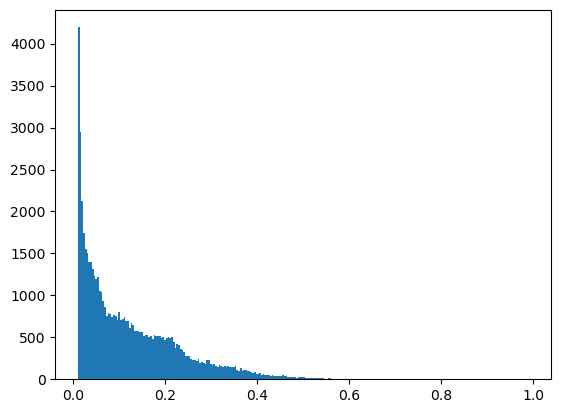

In [8]:
Ga = np.angle(I2, deg=True)
Qa = angle_quantization(Ga)

#Qm = edge_thinning(Gm, Qa)
Qm = edge_thinning(mag, Qa)


#Display histogram of quantized gradients

plt.hist(Qm.ravel(),bins=256, range=(0.01,0.99))

#low = [?, 2x]
#high = [?, 2x]

low = [.05,.1]
high = [.1, .2]

C1 = edge_hysteresis(Qm, low=low[0], high=high[0], threshold=True)
C2 = edge_hysteresis(Qm, low=low[1], high=high[1], threshold=True)

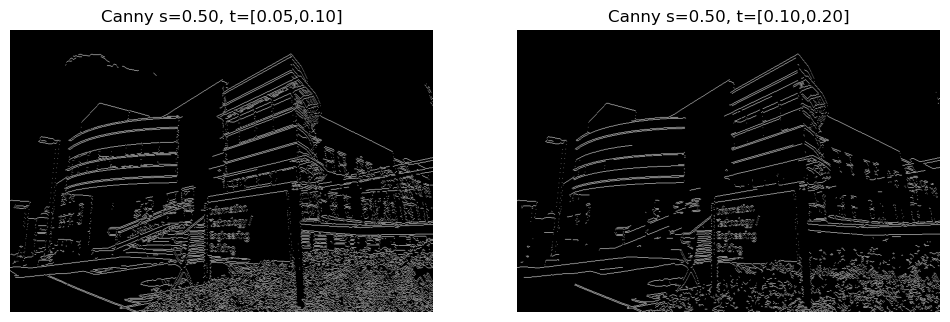

In [9]:
# Binarize Canny edge maps
# Display result w/sigma, contrast scaling, and hysteresis thresholds listed in title
T1 = 'Canny s=%.2f, t=[%.2f,%.2f]' % (sigma, low[0], high[0])
T2 = 'Canny s=%.2f, t=[%.2f,%.2f]' % (sigma, low[1], high[1])
show_images([C1, C2],[T1, T2])


## Observations
When the sigma, and rescale value are set constant, we can see that the image with double the high and low threshold values will produce an image with worse edge detection.